#Data Ingestion

In [ ]:
#Author: Ashish KC 
#Completion Date: March 24th, 2020 
#Finalized Date: March 24th, 2020 

#First we must import all of our dependencies. 

import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import re
from datetime import datetime

%matplotlib inline
plt.style.use('default')

#Here are going to be using PyDrive to access the .xlsx or .json file. 

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#This link is from when you "right-click" on the google drive file of interest and you say "get shareable link", make sure to paste it here. 

link1 = 'https://drive.google.com/open?id=1Jf3Qu0GZrbLywpbHgrb0HMtp6sPevDa-'
link2 = 'https://drive.google.com/open?id=1nX3L2WU9-1RMQcFcJpm6UWsVvfu2yZqw'
link3 = 'https://drive.google.com/open?id=1ykk4WOXabA7tvYnV4BLQRYVK2vcG2UKo'

fluff, id1 = link1.split('=')
fluff, id2 = link2.split('=')
fluff, id3 = link3.split('=')

In [ ]:
downloaded1 = drive.CreateFile({'id':id1})
downloaded1.GetContentFile('EQUIP.json') 

downloaded2 = drive.CreateFile({'id':id2})
downloaded2.GetContentFile('RTS_BOT_PRODUCTION.json') 

downloaded3 = drive.CreateFile({'id':id3})
downloaded3.GetContentFile('VIMS_HAUL_CYCLE_TRANS.csv') 

equip = pd.read_json('EQUIP.json')
rts_bot_prod = pd.read_json('RTS_BOT_PRODUCTION.json', lines = True)
vims_haul_cycle_trans = pd.read_csv('VIMS_HAUL_CYCLE_TRANS.csv')

#Data Processing

##Truck Types

Table: EQUIP 

In [ ]:
#Filter for only haul trucks. 

equip_clean = equip[equip['EQP_TYPE'] == 'H']

#Remove inaccurate EQUIP_IDENT value from series. 

equip_clean = equip_clean[equip_clean.EQUIP_IDENT != '6I31'] 

#Change the datatype of column to integer to sort. 

equip_clean['EQUIP_IDENT'] = pd.to_numeric(equip_clean['EQUIP_IDENT'])

#Only consider haul trucks within the range of 6160 to 6212 (Conventional Haul Trucks). 

equip_clean = equip_clean[(equip_clean['EQUIP_IDENT'] >= 6160)&(equip_clean['EQUIP_IDENT'] <= 6212)]

#Only include necessary columns. 

equip_clean = equip_clean[['EQUIP_IDENT', 'FUEL_CAPACITY','EQMODEL_CODE']]

In [ ]:
equip_clean.head()

,EQUIP_IDENT,FUEL_CAPACITY,EQMODEL_CODE
170,6160,4718,CAT793C
171,6161,4718,CAT793C
172,6162,4718,CAT793C
173,6163,3865,CAT793C
174,6164,4718,CAT793C


##Load & Dump Locations

Table: RTS_BOT_PRODUCTION

In [ ]:
#Convert all datetime columns to datetime data types

rts_bot_prod_clean = rts_bot_prod.drop(['LOAD_START_TIME','EMPTY_TIME','EMPTY_STOPPED_TIME','WAIT_AT_LU','QUEUE_AT_LU','SPOTTING_TIME','SHOVEL_WAITING_TIME','LOADING_TIME','HAULING_TIME','HAULING_STOPPED_TIME','WAIT_AT_DUMP','QUEUE_AT_DUMP','DUMPING_TIME','IDLE','STANDBY','UNSCHEDULED','DELAY','DOWN','SOURCE','DELETED','HU_BADGE_IDENT','LU_BADGE_IDENT','BLOCK_SNAME','PREVIOUS_DUMP_LOCATION','CREW','EMPTY_DISPATCH_ASSIGNED_BY','DATA_ERROR_CODE','LASTUPDATETIMESTAMP','FULL_DISPATCH','LU_IDENT','MATERIAL_DESCRIP','CHANGE_TRACKING_VERSION','CDC_CURRENT_TIMESTAMP','CDC_OP_TYPE','EMPTY_DISPATCH_OVERRIDE','LOAD_CREW','GPS_HAUL_DIST','HAUL_DIST','SHIFT_ALIAS'],axis=1)

rts_bot_prod_clean['START_TIME'] = pd.to_datetime(rts_bot_prod_clean['START_TIME'])
rts_bot_prod_clean['END_TIME'] = pd.to_datetime(rts_bot_prod_clean['END_TIME'])
rts_bot_prod_clean['SHIFT_DATE'] = pd.to_datetime(rts_bot_prod_clean['SHIFT_DATE'])

#Convert columns to PST from UTC 

rts_bot_prod_clean['START_TIME'] = rts_bot_prod_clean['START_TIME'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)
rts_bot_prod_clean['END_TIME'] = rts_bot_prod_clean['END_TIME'].dt.tz_convert('America/Los_Angeles').dt.tz_localize(None)

rts_bot_prod_clean['SHIFT_DATE'] = (rts_bot_prod_clean['SHIFT_DATE']).dt.date

#Sort by START_TIME in ascending order 

rts_bot_prod_clean= rts_bot_prod_clean.sort_values(by = 'SHIFT_DATE', ascending=True)

#Rename column to EQUIP_IDENT for merge later
rts_bot_prod_clean = rts_bot_prod_clean.rename(columns={"HU_IDENT": "EQUIP_IDENT"})

#Only include conventional haul trucks 

rts_bot_prod_clean['EQUIP_IDENT'] = pd.to_numeric(rts_bot_prod_clean['EQUIP_IDENT'])
rts_bot_prod_clean = rts_bot_prod_clean[(rts_bot_prod_clean['EQUIP_IDENT'] >= 6160) & (rts_bot_prod_clean['EQUIP_IDENT'] <= 6212)]

#Only include ore or waste hauls 

rts_bot_prod_clean = rts_bot_prod_clean[(rts_bot_prod_clean['MATERIAL_IDENT'] == 'WRk') | (rts_bot_prod_clean['MATERIAL_IDENT'] == 'Ore')| (rts_bot_prod_clean['MATERIAL_IDENT'] == 'WOB')]

#Convert TOTAL_TIME to Hours 

rts_bot_prod_clean['TOTAL_TIME'] = rts_bot_prod_clean['TOTAL_TIME']/60

#Add month number 

rts_bot_prod_clean['Month'] = rts_bot_prod_clean['START_TIME'].dt.month

In [ ]:
rts_bot_prod_clean.head()

,HAUL_CYCLE_REC_IDENT,START_TIME,END_TIME,SHIFT_DATE,EQUIP_IDENT,TONNES,TOTAL_TIME,EFH_DIST,LOAD_LOCATION,DUMP_LOCATION,MATERIAL_IDENT,Month
349057,5639586,2019-01-01 00:31:07,2019-01-01 01:45:31,2019-01-01,6174,230,0.693055,14.580,V1130e,Jurassic 6.5,WRk,1
57706,5640182,2019-01-01 11:25:53,2019-01-01 11:56:38,2019-01-01,6185,230,0.438057,10.014,L1230b,CR01,Ore,1
57718,5640178,2019-01-01 11:22:29,2019-01-01 11:50:01,2019-01-01,6202,230,0.458888,10.011,L1230b,CR01,Ore,1
57720,5640297,2019-01-01 13:39:59,2019-01-01 14:09:34,2019-01-01,6181,230,0.489723,10.009,L1230b,CR01,Ore,1
57765,5640395,2019-01-01 15:14:27,2019-01-01 15:40:40,2019-01-01,6202,230,0.436945,10.023,L1230b,CR01,Ore,1


In [ ]:
#Groupby LOAD_LOCATION and DUMP_LOCATION to determine which haul has the most data 

rts_groupby = rts_bot_prod_clean.groupby(['LOAD_LOCATION', 'DUMP_LOCATION','MATERIAL_IDENT']).size().reset_index(name='CYCLE_COUNT')
rts_groupby = rts_groupby.sort_values(['CYCLE_COUNT'], ascending = False)
rts_groupby = rts_groupby[rts_groupby['CYCLE_COUNT'] <= 3500]
rts_groupby.head()

,LOAD_LOCATION,DUMP_LOCATION,MATERIAL_IDENT,CYCLE_COUNT
155,L1200d,CR01,Ore,3274
212,L1230b,CR01,Ore,3086
642,V1085g,CR04,Ore,3062
918,V1115f,CR05,Ore,2864
467,V1070e,24 Mile 1,WRk,2755


##Fuel Consumed

In [ ]:
#Drop unused series. 

vims_haul_cycle_trans_clean = vims_haul_cycle_trans.drop(['LOADER_PASS_COUNT','STOPPED_EMPTY_TIME','LOADING_TIME','TRAVEL_EMPTY_TIME','TRAVEL_EMPTY_DISTANCE','STOPPED_LOADED_TIME','TRAVEL_LOADED_TIME','TRAVEL_LOADED_DISTANCE'], axis=1)

#Convert TIMESTAMP to datetime value and sort by timestamp. 

vims_haul_cycle_trans_clean['TIMESTAMP'] = pd.to_datetime(vims_haul_cycle_trans['TIMESTAMP'])
vims_haul_cycle_trans_clean= vims_haul_cycle_trans_clean.sort_values(by = 'TIMESTAMP', ascending=True)

#Change HAUL_CYCLE_REC_IDENT to be int64 data type to match EQUIP_STATUS_REC_IDENT by replacing an NaN values with 9999999.

vims_haul_cycle_trans_clean.HAUL_CYCLE_REC_IDENT = vims_haul_cycle_trans_clean.HAUL_CYCLE_REC_IDENT.fillna(9999999).astype(int)

#Filter for only valid HAUL_CYCLE_REC_IDENTs 

vims_haul_cycle_trans_clean = vims_haul_cycle_trans_clean[(vims_haul_cycle_trans_clean['HAUL_CYCLE_REC_IDENT'] != 9999999) & (vims_haul_cycle_trans_clean['HAUL_CYCLE_REC_IDENT'] > 0)]

In [ ]:
vims_haul_cycle_trans_clean.head()

,TIMESTAMP,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT
0,2019-01-01 08:18:16,6191,2,34.875,5639948
1,2019-01-01 08:25:25,6187,2,31.750,5639964
2,2019-01-01 08:27:39,6207,2,37.500,5639990
3,2019-01-01 08:31:24,6188,2,16.000,5639971
4,2019-01-01 08:33:52,6193,2,17.250,5639969


In [ ]:
#Include Truck Type within the following dataframe 

vims_haul_cycle_trans_clean = pd.merge(vims_haul_cycle_trans_clean, equip_clean, how = 'left', on = 'EQUIP_IDENT')

In [ ]:
#Inner join of RTS_BOT_PROD_CLEAN on VIMS_HAUL_CYCLE_TRANS_CLEAN 

rts_bot_prod_clean = pd.merge(vims_haul_cycle_trans_clean,rts_bot_prod_clean, how = 'inner', on = ['HAUL_CYCLE_REC_IDENT','EQUIP_IDENT'])

#Calculate FE Index from the identified features 

rts_bot_prod_clean['FE_Index'] = (rts_bot_prod_clean['FUEL_USED_IN_CYCLE'] * rts_bot_prod_clean['TOTAL_TIME']) /(rts_bot_prod_clean['EFH_DIST'] * rts_bot_prod_clean['TONNES'])

rts_bot_prod_clean.head()

,TIMESTAMP,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,EQMODEL_CODE,START_TIME,END_TIME,SHIFT_DATE,TONNES,TOTAL_TIME,EFH_DIST,LOAD_LOCATION,DUMP_LOCATION,MATERIAL_IDENT,Month,FE_Index
0,2019-01-01 08:18:16,6191,2,34.875,5639948,4462,CAT793D,2019-01-01 06:53:40,2019-01-01 08:18:13,2019-01-01,230,0.569168,12.406,V1100h,I9-1280,WRk,1,0.006957
1,2019-01-01 08:25:25,6187,2,31.750,5639964,4462,CAT793D,2019-01-01 07:15:17,2019-01-01 08:25:33,2019-01-01,230,0.513612,10.737,V1100h,Val Crush,WRk,1,0.006603
2,2019-01-01 08:27:39,6207,2,37.500,5639990,4462,CAT793D,2019-01-01 08:16:03,2019-01-01 08:27:42,2019-01-01,230,0.194167,13.153,V1100h,Jurassic 6.5,WRk,1,0.002407
3,2019-01-01 08:31:24,6188,2,16.000,5639971,4462,CAT793D,2019-01-01 07:23:40,2019-01-01 08:30:17,2019-01-01,230,0.298888,4.420,V1100g,CR05,Ore,1,0.004704
4,2019-01-01 08:33:52,6193,2,17.250,5639969,4462,CAT793D,2019-01-01 07:21:53,2019-01-01 08:34:01,2019-01-01,230,0.391112,4.420,V1100g,CR05,Ore,1,0.006637


#Haulage Analysis

##Functions

In [ ]:
def outlier_investigation(haul): 

  Q1_fuel = haul['FUEL_USED_IN_CYCLE'].quantile(0.25)
  Q3_fuel = haul['FUEL_USED_IN_CYCLE'].quantile(0.75)
  IQR_fuel = Q3_fuel - Q1_fuel
  Maximum_fuel = Q3_fuel + 1.5 * IQR_fuel
  Minimum_fuel = Q1_fuel - 1.5 * IQR_fuel

  Q1_time = haul['TOTAL_TIME'].quantile(0.25) 
  Q3_time = haul['TOTAL_TIME'].quantile(0.75)
  IQR_time = Q3_time - Q1_time
  Maximum_time = Q3_time + 1.5 * IQR_time
  Minimum_time = Q1_time - 1.5 * IQR_time

  Q1_EFH = haul['EFH_DIST'].quantile(0.25)
  Q3_EFH = haul['EFH_DIST'].quantile(0.75)
  IQR_EFH = Q3_EFH - Q1_EFH
  Maximum_EFH = Q3_EFH + 1.5 * IQR_EFH
  Minimum_EFH = Q1_EFH - 1.5 * IQR_EFH

  Q1_FE_Index = haul['FE_Index'].quantile(0.25)
  Q3_FE_Index = haul['FE_Index'].quantile(0.75)
  IQR_FE_Index = Q3_FE_Index - Q1_FE_Index
  Maximum_FE_Index = Q3_FE_Index + 1.5 * IQR_FE_Index
  Minimum_FE_Index = Q1_FE_Index - 1.5 * IQR_FE_Index

  haul = haul[(haul['FUEL_USED_IN_CYCLE'] > Minimum_fuel) & (haul['FUEL_USED_IN_CYCLE'] < Maximum_fuel) & (haul['TOTAL_TIME'] > Minimum_time) & (haul['TOTAL_TIME'] < Maximum_time) & (haul['EFH_DIST'] > Minimum_EFH) & (haul['EFH_DIST'] < Maximum_EFH) & (haul['FE_Index'] > Minimum_FE_Index) & (haul['FE_Index'] < Maximum_FE_Index)]

  return haul

In [ ]:
def month_groupby(haul):

  haul_groupby = haul.groupby('Month')['HAUL_CYCLE_REC_IDENT'].count()
  haul_groupby = haul_groupby.sort_values(ascending=False).reset_index(drop=False)
  Top_Month = haul_groupby.iloc[0]['Month']

  return print(Top_Month)

In [ ]:
def split_trucktype(haul):
  
  haul_C = haul[haul['EQMODEL_CODE'] == 'CAT793C']
  haul_D = haul[haul['EQMODEL_CODE'] == 'CAT793D']

  return haul_C, haul_D

##Haul #1 - November

  * Duration: 2019-10-31 20:00:00 - 2019-11-30 8:00:00
  * Load Location: L1140c
  * Dump Location: CR01
  * Number of Points: 2016

#####Raw Data

In [ ]:
#Isolate haul by load location, dump location, and month with the most amount of cycles. 

haul_1 = rts_bot_prod_clean[(rts_bot_prod_clean['LOAD_LOCATION'] == 'L1140c') & (rts_bot_prod_clean['DUMP_LOCATION'] == 'CR01')]

#Using user-generated function to determine month with the most cycles 

top_month_haul_1 = month_groupby(haul_1)

10


In [ ]:
#From the top month isolate haul for specific month based upon timestamp column

haul_1 = haul_1[(haul_1['TIMESTAMP'] >= '2019-10-31 20:00:00') & (haul_1['TIMESTAMP'] < '2019-11-30 8:00:00')]
haul_1.head() 

,TIMESTAMP,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,EQMODEL_CODE,START_TIME,END_TIME,SHIFT_DATE,TONNES,TOTAL_TIME,EFH_DIST,LOAD_LOCATION,DUMP_LOCATION,MATERIAL_IDENT,Month,FE_Index
298391,2019-11-02 04:57:53,6196,1,30.75,5983276,4462,CAT793D,2019-11-02 04:49:29,2019-11-02 05:58:01,2019-11-02,230,0.503890,11.678,L1140c,CR01,Ore,11,0.005769
298395,2019-11-02 05:01:19,6180,1,33.50,5983273,4462,CAT793C,2019-11-02 04:46:44,2019-11-02 06:01:30,2019-11-02,230,0.588332,11.659,L1140c,CR01,Ore,11,0.007350
298487,2019-11-02 07:29:17,6206,2,28.00,5983399,4462,CAT793D,2019-11-02 07:43:42,2019-11-02 08:29:28,2019-11-02,230,0.386112,11.687,L1140c,CR01,Ore,11,0.004022
298492,2019-11-02 07:35:53,6180,2,26.75,5983390,4462,CAT793C,2019-11-02 07:29:20,2019-11-02 08:35:56,2019-11-02,230,0.514445,11.685,L1140c,CR01,Ore,11,0.005120
298580,2019-11-02 09:31:40,6196,2,30.00,5983478,4462,CAT793D,2019-11-02 09:52:19,2019-11-02 10:31:44,2019-11-02,230,0.401668,11.674,L1140c,CR01,Ore,11,0.004488


#####Outliers Investigation

In [ ]:
#Unprocessed descriptive statistical summary 

haul_1.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,2445.000000,2445.000000,2445.000000,2.445000e+03,2445.000000,2445.0,2445.000000,2445.000000,2445.0,2445.000000
mean,6191.390593,1.452352,1204.291378,6.005397e+06,4411.910020,230.0,0.546137,11.797124,11.0,0.264463
std,13.520306,0.497826,27235.218548,5.993851e+03,166.086176,0.0,0.090580,0.479874,0.0,6.127663
min,6160.000000,1.000000,1.625000,5.983273e+06,3865.000000,230.0,0.073335,0.597000,11.0,0.000048
25%,6177.000000,1.000000,29.250000,6.002337e+06,4462.000000,230.0,0.495832,11.578000,11.0,0.005448
50%,6192.000000,1.000000,30.625000,6.007166e+06,4462.000000,230.0,0.530557,11.802000,11.0,0.006002
75%,6205.000000,2.000000,32.500000,6.009815e+06,4462.000000,230.0,0.578887,11.837000,11.0,0.006827
max,6210.000000,2.000000,807138.250000,6.012621e+06,4718.000000,230.0,1.818887,14.315000,11.0,193.955366


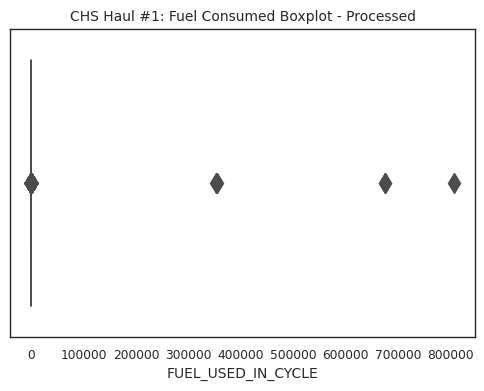

In [ ]:
#Unprocess box plot distributions for Fuel Used in Cycle 

plt.figure(figsize=(6,4))
sns.boxplot(haul_1['FUEL_USED_IN_CYCLE'], fliersize = 10)
plt.title('CHS Haul #1: Fuel Consumed Boxplot - Processed', fontsize = 10)
plt.xlabel('FUEL_USED_IN_CYCLE',fontsize=10)

plt.show()

In [ ]:
#Perform outlier investigation through using user-generated functions above 

haul_1 = outlier_investigation(haul_1)

#Split into truck types for further data analysis

haul_1_C, haul_1_D= split_trucktype(haul_1)

#####Processed Dataframe

In [ ]:
#Descriptive Statistical summary for Haul 1

haul_1.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,2016.000000,2016.000000,2016.000000,2.016000e+03,2016.000000,2016.0,2016.000000,2016.000000,2016.0,2016.000000
mean,6191.431548,1.457341,30.503910,6.005539e+06,4411.784722,230.0,0.528137,11.748526,11.0,0.005981
std,13.548746,0.498301,2.031272,6.067369e+03,166.069095,0.0,0.055716,0.162042,0.0,0.000884
min,6160.000000,1.000000,24.500000,5.983273e+06,3865.000000,230.0,0.384167,11.463000,11.0,0.003709
25%,6177.000000,1.000000,29.124548,6.002476e+06,4462.000000,230.0,0.491599,11.574750,11.0,0.005383
50%,6193.000000,1.000000,30.250000,6.007346e+06,4462.000000,230.0,0.522639,11.796000,11.0,0.005859
75%,6205.000000,2.000000,31.750000,6.009986e+06,4462.000000,230.0,0.560000,11.826000,11.0,0.006526
max,6210.000000,2.000000,37.250000,6.012621e+06,4718.000000,230.0,0.700278,12.225000,11.0,0.008875


In [ ]:
#Descriptive Statistical summary for Haul 1

haul_1_C.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,584.000000,584.000000,584.000000,5.840000e+02,584.00000,584.0,584.000000,584.000000,584.0,584.000000
mean,6173.792808,1.476027,29.837983,6.004887e+06,4288.65411,230.0,0.538477,11.745911,11.0,0.005968
std,3.395065,0.499853,2.027924,6.308045e+03,271.91768,0.0,0.052499,0.157118,0.0,0.000869
min,6160.000000,1.000000,24.500000,5.983273e+06,3865.00000,230.0,0.384167,11.486000,11.0,0.003709
25%,6172.000000,1.000000,28.500000,6.001182e+06,3865.00000,230.0,0.500557,11.579000,11.0,0.005357
50%,6175.000000,1.000000,29.750000,6.007093e+06,4462.00000,230.0,0.530973,11.800000,11.0,0.005824
75%,6176.000000,2.000000,31.000000,6.009547e+06,4462.00000,230.0,0.571460,11.829000,11.0,0.006487
max,6180.000000,2.000000,36.750000,6.012621e+06,4718.00000,230.0,0.693333,12.225000,11.0,0.008696


In [ ]:
#Descriptive Statistical summary for Haul 1

haul_1_D.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,1432.000000,1432.000000,1432.000000,1.432000e+03,1432.0,1432.0,1432.000000,1432.000000,1432.0,1432.000000
mean,6198.625000,1.449721,30.775489,6.005804e+06,4462.0,230.0,0.523919,11.749592,11.0,0.005986
std,8.662216,0.497639,1.969695,5.948221e+03,0.0,0.0,0.056452,0.164050,0.0,0.000891
min,6182.000000,1.000000,26.250000,5.983276e+06,4462.0,230.0,0.386112,11.463000,11.0,0.003867
25%,6191.000000,1.000000,29.375000,6.004556e+06,4462.0,230.0,0.486735,11.572750,11.0,0.005403
50%,6202.000000,1.000000,30.500000,6.007474e+06,4462.0,230.0,0.518333,11.794000,11.0,0.005874
75%,6206.000000,2.000000,32.125000,6.010169e+06,4462.0,230.0,0.556943,11.825000,11.0,0.006549
max,6210.000000,2.000000,37.250000,6.012617e+06,4462.0,230.0,0.700278,12.224000,11.0,0.008875


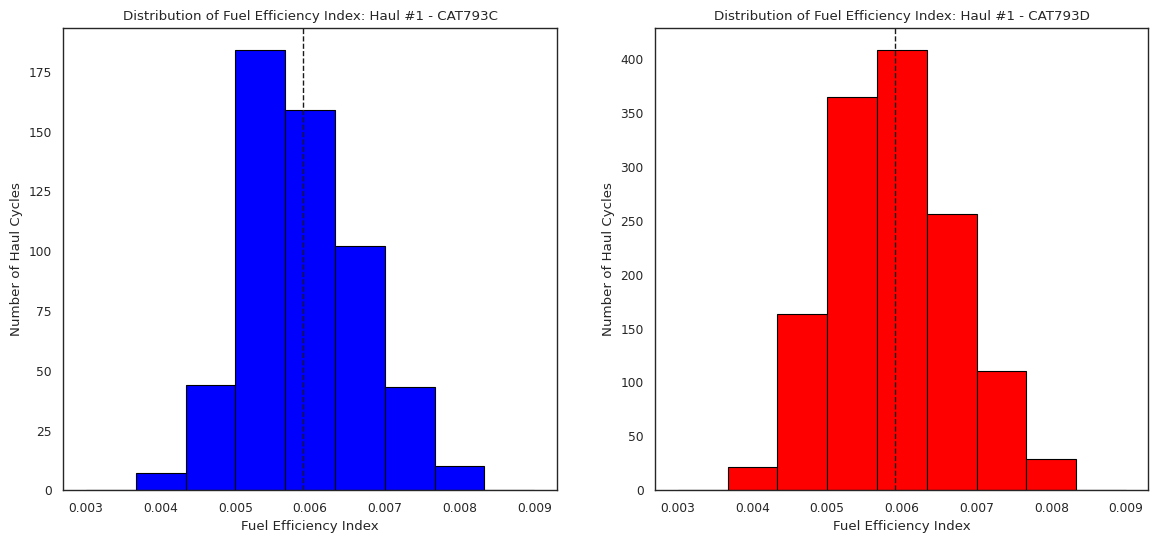

In [ ]:
#Distribution plots of FE Index for Haul #1 truck types C and D 

fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].hist(haul_1_C['FE_Index'], bins=np.linspace(0.003,0.009,10), color = 'blue', edgecolor = 'black')
ax[0].axvline(haul_1_C.FE_Index.mean(), color='k', linestyle='dashed', linewidth=1)
ax[0].set(xlabel='Fuel Efficiency Index',ylabel='Number of Haul Cycles')
ax[0].set_title('Distribution of Fuel Efficiency Index: Haul #1 - CAT793C')

ax[1].hist(haul_1_D['FE_Index'], bins=np.linspace(0.003,0.009,10), color = 'red', edgecolor = 'black')
ax[1].axvline(haul_1_D.FE_Index.mean(), color='k', linestyle='dashed', linewidth=1)
ax[1].set(xlabel='Fuel Efficiency Index',ylabel='Number of Haul Cycles')
ax[1].set_title('Distribution of Fuel Efficiency Index: Haul #1 - CAT793D')

plt.show()

##Haul #2 - September:

  * Duration: 2019-08-30 20:00:00 - 2019-09-30 8:00:00
  * Load Location: V1100d
  * Dump Location: 24 Mile 1
  * Number of Points: 2905 

######Raw Data

In [ ]:
haul_2 = rts_bot_prod_clean[(rts_bot_prod_clean['LOAD_LOCATION'] == 'V1100d') & (rts_bot_prod_clean['DUMP_LOCATION'] == '24 Mile 1')]

#Using user-generated function to determine month with the most cycles 

top_month_haul_2 = month_groupby(haul_2)

9


In [ ]:
haul_2 = haul_2[(haul_2['TIMESTAMP'] >= '2019-08-30 20:00:00') & (haul_2['TIMESTAMP'] < '2019-09-30 8:00:00')]
haul_2.head()

,TIMESTAMP,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,EQMODEL_CODE,START_TIME,END_TIME,SHIFT_DATE,TONNES,TOTAL_TIME,EFH_DIST,LOAD_LOCATION,DUMP_LOCATION,MATERIAL_IDENT,Month,FE_Index
242511,2019-08-30 20:10:26,6190,1,25.375,5918836,4462,CAT793D,2019-08-30 20:43:14,2019-08-30 21:10:30,2019-08-31,230,0.454443,12.153,V1100d,24 Mile 1,WRk,8,0.004125
242512,2019-08-30 20:10:45,6175,1,31.250,5918827,3865,CAT793C,2019-08-30 20:24:27,2019-08-30 21:07:10,2019-08-31,230,0.711943,12.137,V1100d,24 Mile 1,WRk,8,0.007970
242516,2019-08-30 20:12:25,6165,1,39.250,5918257,3865,CAT793C,2019-08-30 07:25:05,2019-08-30 21:12:28,2019-08-31,230,0.713333,12.156,V1100d,24 Mile 1,WRk,8,0.010014
242530,2019-08-30 20:32:54,6172,1,29.000,5918846,4462,CAT793C,2019-08-30 20:52:48,2019-08-30 21:32:16,2019-08-31,230,0.657780,12.171,V1100d,24 Mile 1,WRk,8,0.006814
242540,2019-08-30 20:44:04,6204,1,26.125,5918856,4462,CAT793D,2019-08-30 21:03:53,2019-08-30 21:43:49,2019-08-31,230,0.665557,12.197,V1100d,24 Mile 1,WRk,8,0.006198


#####Outliers Investigation

In [ ]:
haul_2= outlier_investigation(haul_2)
haul_2_C, haul_2_D = split_trucktype(haul_2)

#####Processed Dataframe

In [ ]:
haul_2.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,2905.000000,2905.000000,2905.000000,2.905000e+03,2905.000000,2905.0,2905.000000,2905.000000,2905.000000,2905.000000
mean,6184.221687,1.486059,32.282816,5.932426e+06,4416.182788,230.0,0.622324,12.490760,8.908090,0.007024
std,13.637793,0.499892,2.609263,9.739768e+03,205.197874,0.0,0.070411,0.159157,0.288949,0.001172
min,6160.000000,1.000000,25.287838,5.918257e+06,3865.000000,230.0,0.421112,12.042000,8.000000,0.003829
25%,6173.000000,1.000000,30.500000,5.924260e+06,4462.000000,230.0,0.571945,12.380000,9.000000,0.006196
50%,6183.000000,1.000000,32.151772,5.927919e+06,4462.000000,230.0,0.620555,12.471000,9.000000,0.006932
75%,6194.000000,2.000000,33.875000,5.943260e+06,4462.000000,230.0,0.669167,12.594000,9.000000,0.007813
max,6210.000000,2.000000,39.625000,5.947048e+06,4718.000000,230.0,0.830278,12.954000,9.000000,0.010562


In [ ]:
haul_2_C.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,1251.000000,1251.000000,1251.000000,1.251000e+03,1251.000000,1251.0,1251.000000,1251.000000,1251.000000,1251.000000
mean,6171.313349,1.501998,31.767150,5.931286e+06,4355.605915,230.0,0.626499,12.475007,8.916067,0.006971
std,6.397823,0.500196,2.710124,9.229067e+03,302.276150,0.0,0.068983,0.152183,0.277398,0.001191
min,6160.000000,1.000000,25.287838,5.918257e+06,3865.000000,230.0,0.423888,12.122000,8.000000,0.003860
25%,6165.000000,1.000000,29.925405,5.924336e+06,3865.000000,230.0,0.578751,12.378000,9.000000,0.006146
50%,6172.000000,2.000000,31.513325,5.926964e+06,4462.000000,230.0,0.623333,12.443000,9.000000,0.006878
75%,6177.000000,2.000000,33.750000,5.941756e+06,4462.000000,230.0,0.673335,12.567500,9.000000,0.007732
max,6181.000000,2.000000,39.250000,5.947045e+06,4718.000000,230.0,0.830278,12.929000,9.000000,0.010562


In [ ]:
haul_2_D.describe()

,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,TONNES,TOTAL_TIME,EFH_DIST,Month,FE_Index
count,1654.000000,1654.000000,1654.000000,1.654000e+03,1654.0,1654.0,1654.000000,1654.000000,1654.000000,1654.000000
mean,6193.984885,1.474002,32.672839,5.933289e+06,4462.0,230.0,0.619167,12.502674,8.902056,0.007064
std,8.620542,0.499475,2.460326,1.002587e+04,0.0,0.0,0.071331,0.163274,0.297329,0.001157
min,6182.000000,1.000000,25.375000,5.918836e+06,4462.0,230.0,0.421112,12.042000,8.000000,0.003829
25%,6187.000000,1.000000,31.125000,5.924222e+06,4462.0,230.0,0.568612,12.380000,9.000000,0.006216
50%,6192.000000,1.000000,32.500000,5.929025e+06,4462.0,230.0,0.617362,12.493000,9.000000,0.006973
75%,6202.000000,2.000000,34.000000,5.943577e+06,4462.0,230.0,0.666874,12.614750,9.000000,0.007843
max,6210.000000,2.000000,39.625000,5.947048e+06,4462.0,230.0,0.825833,12.954000,9.000000,0.010442


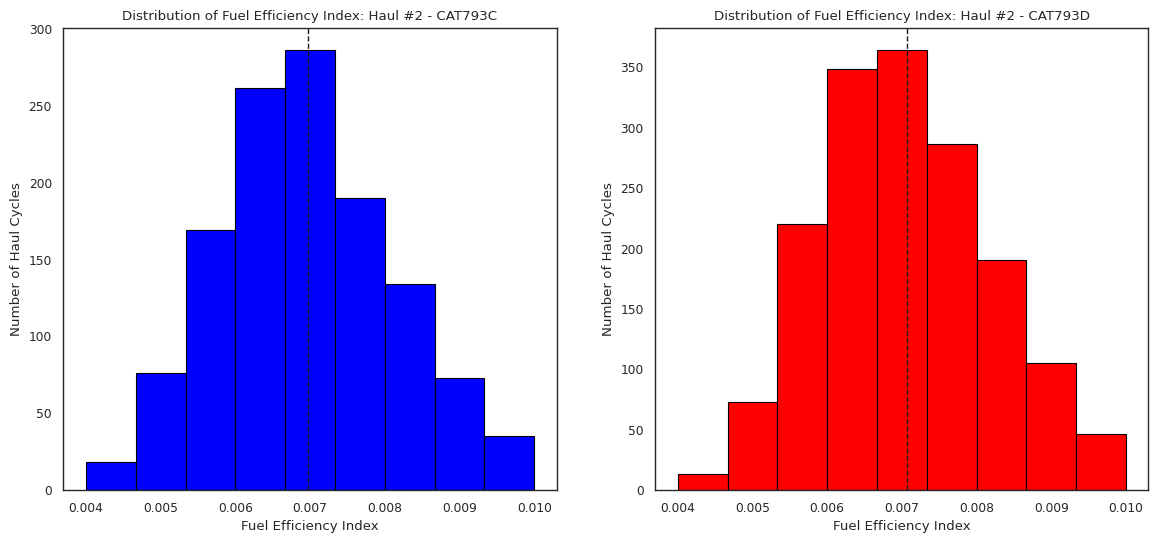

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,6))

ax[0].hist(haul_2_C['FE_Index'], bins=np.linspace(0.004,0.010,10), color = 'blue', edgecolor = 'black')
ax[0].axvline(haul_2_C.FE_Index.mean(), color='k', linestyle='dashed', linewidth=1)
ax[0].set(xlabel='Fuel Efficiency Index',ylabel='Number of Haul Cycles')
ax[0].set_title('Distribution of Fuel Efficiency Index: Haul #2 - CAT793C')

ax[1].hist(haul_2_D['FE_Index'], bins=np.linspace(0.004,0.010,10), color = 'red', edgecolor = 'black')
ax[1].axvline(haul_2_D.FE_Index.mean(), color='k', linestyle='dashed', linewidth=1)
ax[1].set(xlabel='Fuel Efficiency Index',ylabel='Number of Haul Cycles')
ax[1].set_title('Distribution of Fuel Efficiency Index: Haul #2 - CAT793D')

plt.show()

##Haul #3 - November

  * Duration: 2019-08-31 20:00:00 - 2019-09-30 8:00:00
  * Load Location: V1070e
  * Dump Location: 24 Mile 1
  * Number of Points: 1512

#####Raw Data

In [ ]:
haul_3 = rts_bot_prod_clean[(rts_bot_prod_clean['LOAD_LOCATION'] == 'V1070e') & (rts_bot_prod_clean['DUMP_LOCATION'] == '24 Mile 1')]

#Using user-generated function to determine month with the most cycles 

top_month_haul_3 = month_groupby(haul_3)

12


In [ ]:
haul_3 = haul_3[(haul_3['TIMESTAMP'] >= '2019-11-30 20:00:00') & (haul_3['TIMESTAMP'] < '2019-12-31 8:00:00')]
haul_3.head()

,TIMESTAMP,EQUIP_IDENT,SHIFT_IDENT,FUEL_USED_IN_CYCLE,HAUL_CYCLE_REC_IDENT,FUEL_CAPACITY,EQMODEL_CODE,START_TIME,END_TIME,SHIFT_DATE,TONNES,TOTAL_TIME,EFH_DIST,LOAD_LOCATION,DUMP_LOCATION,MATERIAL_IDENT,Month,FE_Index
323523,2019-11-30 20:43:41,6209,1,36.625000,6013161,4462,CAT793D,2019-11-30 19:17:29,2019-11-30 20:43:36,2019-12-01,230,0.704722,12.670,V1070e,24 Mile 1,WRk,11,0.008857
323535,2019-11-30 21:01:15,6183,1,27.875000,6013186,4462,CAT793D,2019-11-30 20:23:05,2019-11-30 21:01:22,2019-12-01,230,0.623888,12.816,V1070e,24 Mile 1,WRk,11,0.005900
323536,2019-11-30 21:02:35,6171,1,33.213917,6013173,3865,CAT793C,2019-11-30 19:27:54,2019-11-30 21:02:38,2019-12-01,230,0.760278,12.808,V1070e,24 Mile 1,WRk,11,0.008572
323540,2019-11-30 21:08:25,6206,1,34.375000,6013181,4462,CAT793D,2019-11-30 18:38:11,2019-11-30 20:07:55,2019-12-01,230,0.943055,12.795,V1070e,24 Mile 1,WRk,11,0.011016
323541,2019-11-30 21:09:11,6172,1,60.250000,6012637,4462,CAT793C,2019-11-30 06:25:24,2019-11-30 20:09:21,2019-12-01,230,0.907223,12.552,V1070e,24 Mile 1,WRk,11,0.018933


#####Outliers Investigation

In [ ]:
haul_3.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EQUIP_IDENT,1725.0,6.188186e+03,13.654743,6160.000,6.177000e+03,6.188000e+03,6.201000e+03,6.210000e+03
SHIFT_IDENT,1725.0,1.253333e+00,0.435046,1.000,1.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
FUEL_USED_IN_CYCLE,1725.0,3.062240e+01,5.074364,4.375,2.737500e+01,3.025000e+01,3.287500e+01,7.325000e+01
HAUL_CYCLE_REC_IDENT,1725.0,6.026824e+06,9725.138544,6010562.000,6.017611e+06,6.022424e+06,6.036346e+06,6.043279e+06
FUEL_CAPACITY,1725.0,4.424133e+03,167.784372,3865.000,4.462000e+03,4.462000e+03,4.462000e+03,4.718000e+03
TONNES,1725.0,2.300000e+02,0.000000,230.000,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02
TOTAL_TIME,1725.0,6.515032e-01,0.444968,0.000,5.541667e-01,6.175000e-01,6.902783e-01,6.544167e+00
EFH_DIST,1725.0,1.290270e+01,0.247512,12.062,1.278600e+01,1.287300e+01,1.293900e+01,1.405400e+01
Month,1725.0,1.198667e+01,0.114731,11.000,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
FE_Index,1725.0,6.863626e-03,0.005509,0.000,5.128842e-03,6.327104e-03,7.524528e-03,9.302338e-02


In [ ]:
haul_3 = outlier_investigation(haul_3)
haul_3_C, haul_3_D = split_trucktype(haul_3)

#####Processed Dataframe

In [ ]:
haul_3.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EQUIP_IDENT,1512.0,6.188226e+03,13.710056,6.160000e+03,6.177000e+03,6.188000e+03,6.201000e+03,6.210000e+03
SHIFT_IDENT,1512.0,1.228836e+00,0.420222,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
FUEL_USED_IN_CYCLE,1512.0,2.994478e+01,3.564145,2.225000e+01,2.712500e+01,2.987500e+01,3.225000e+01,4.087500e+01
HAUL_CYCLE_REC_IDENT,1512.0,6.026845e+06,9685.385579,6.013161e+06,6.017662e+06,6.022327e+06,6.036401e+06,6.043279e+06
FUEL_CAPACITY,1512.0,4.424382e+03,169.458297,3.865000e+03,4.462000e+03,4.462000e+03,4.462000e+03,4.718000e+03
TONNES,1512.0,2.300000e+02,0.000000,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02
TOTAL_TIME,1512.0,6.169145e-01,0.086358,3.716667e-01,5.519462e-01,6.127775e-01,6.820154e-01,8.830533e-01
EFH_DIST,1512.0,1.285987e+01,0.097975,1.257200e+01,1.278500e+01,1.286900e+01,1.293000e+01,1.316100e+01
Month,1512.0,1.198942e+01,0.102357,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
FE_Index,1512.0,6.314068e-03,0.001481,3.256084e-03,5.119156e-03,6.247091e-03,7.310452e-03,1.107788e-02


In [ ]:
haul_3_C.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EQUIP_IDENT,539.0,6.173226e+03,5.742036,6.160000e+03,6.170000e+03,6.174000e+03,6.177000e+03,6.181000e+03
SHIFT_IDENT,539.0,1.243043e+00,0.429319,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
FUEL_USED_IN_CYCLE,539.0,2.916259e+01,3.373525,2.250000e+01,2.650000e+01,2.925000e+01,3.150000e+01,3.925000e+01
HAUL_CYCLE_REC_IDENT,539.0,6.025888e+06,9611.093293,6.013173e+06,6.017447e+06,6.021134e+06,6.036221e+06,6.043235e+06
FUEL_CAPACITY,539.0,4.356475e+03,271.056094,3.865000e+03,4.462000e+03,4.462000e+03,4.462000e+03,4.718000e+03
TONNES,539.0,2.300000e+02,0.000000,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02
TOTAL_TIME,539.0,6.201654e-01,0.085855,3.813900e-01,5.561108e-01,6.175017e-01,6.862500e-01,8.830533e-01
EFH_DIST,539.0,1.285738e+01,0.100636,1.257200e+01,1.277950e+01,1.286400e+01,1.293200e+01,1.315700e+01
Month,539.0,1.199072e+01,0.095956,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
FE_Index,539.0,6.187398e-03,0.001453,3.256084e-03,5.003731e-03,6.153594e-03,7.188500e-03,1.061075e-02


In [ ]:
haul_3_D.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
EQUIP_IDENT,973.0,6.196534e+03,8.948992,6.182000e+03,6.189000e+03,6.195000e+03,6.206000e+03,6.210000e+03
SHIFT_IDENT,973.0,1.220966e+00,0.415111,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00
FUEL_USED_IN_CYCLE,973.0,3.037808e+01,3.594574,2.225000e+01,2.750000e+01,3.037500e+01,3.275000e+01,4.087500e+01
HAUL_CYCLE_REC_IDENT,973.0,6.027376e+06,9690.554565,6.013161e+06,6.018464e+06,6.031602e+06,6.036491e+06,6.043279e+06
FUEL_CAPACITY,973.0,4.462000e+03,0.000000,4.462000e+03,4.462000e+03,4.462000e+03,4.462000e+03,4.462000e+03
TONNES,973.0,2.300000e+02,0.000000,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02,2.300000e+02
TOTAL_TIME,973.0,6.151136e-01,0.086627,3.716667e-01,5.511133e-01,6.097233e-01,6.802783e-01,8.605550e-01
EFH_DIST,973.0,1.286125e+01,0.096495,1.258700e+01,1.278700e+01,1.287000e+01,1.292800e+01,1.316100e+01
Month,973.0,1.198869e+01,0.105778,1.100000e+01,1.200000e+01,1.200000e+01,1.200000e+01,1.200000e+01
FE_Index,973.0,6.384238e-03,0.001492,3.366679e-03,5.222018e-03,6.299478e-03,7.350442e-03,1.107788e-02


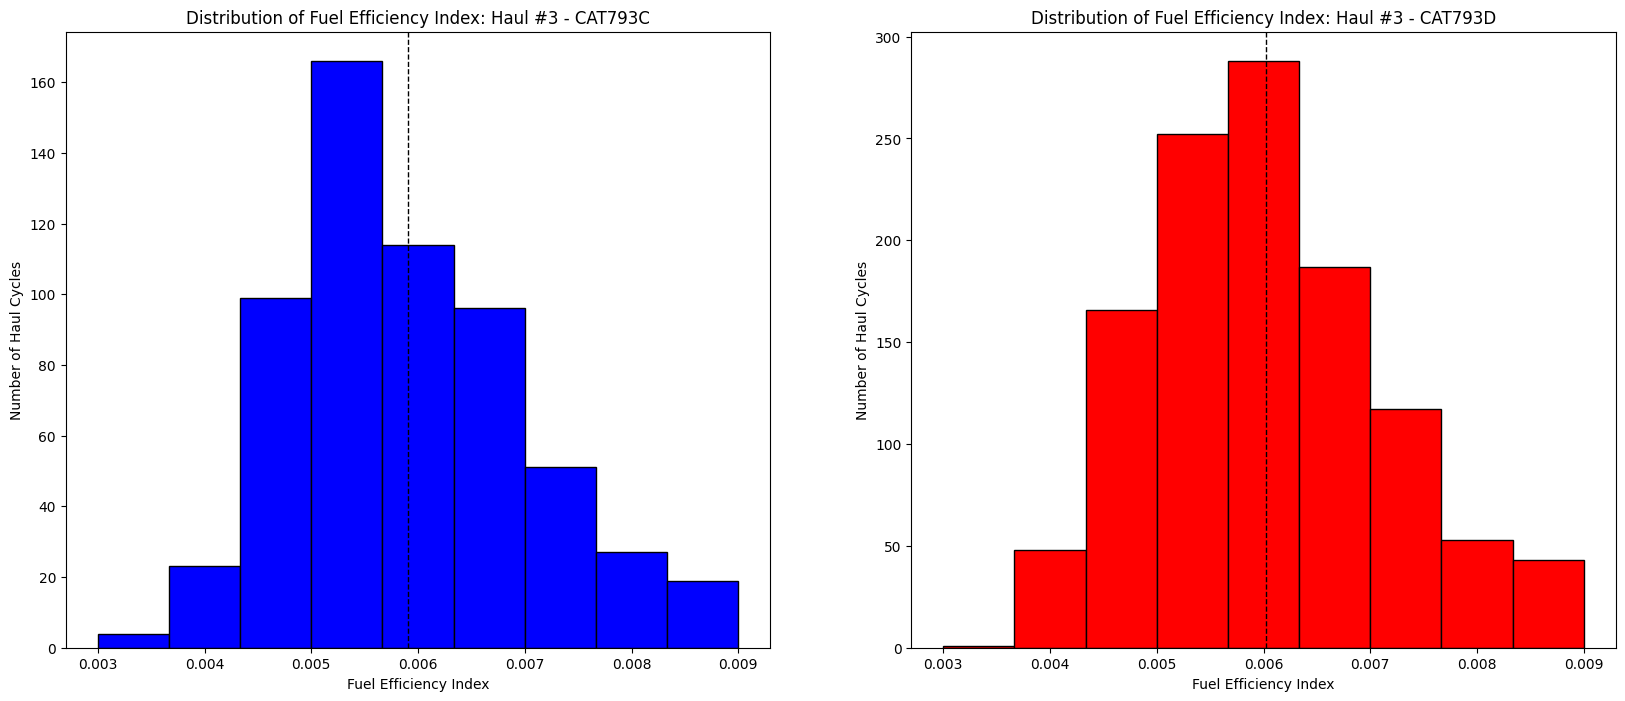

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,8))

ax[0].hist(haul_3_C['FE_Index'], bins=np.linspace(0.003,0.009,10), color = 'blue', edgecolor = 'black')
ax[0].axvline(haul_3_C.FE_Index.mean(), color='k', linestyle='dashed', linewidth=1)
ax[0].set(xlabel='Fuel Efficiency Index',ylabel='Number of Haul Cycles')
ax[0].set_title('Distribution of Fuel Efficiency Index: Haul #3 - CAT793C')

ax[1].hist(haul_3_D['FE_Index'], bins=np.linspace(0.003,0.009,10), color = 'red', edgecolor = 'black')
ax[1].axvline(haul_3_D.FE_Index.mean(), color='k', linestyle='dashed', linewidth=1)
ax[1].set(xlabel='Fuel Efficiency Index',ylabel='Number of Haul Cycles')
ax[1].set_title('Distribution of Fuel Efficiency Index: Haul #3 - CAT793D')

plt.show()

#Download Dataframes

In [ ]:
#The following is to download the processed dataframe into excel files. 

# from google.colab import files
# haul_1_C.to_excel('CHS_Haul_1_C.xlsx') 
# haul_1_D.to_excel('CHS_Haul_1_D.xlsx') 
# haul_2_C.to_excel('CHS_Haul_2_C.xlsx') 
# haul_2_D.to_excel('CHS_Haul_2_D.xlsx') 
# haul_3_C.to_excel('CHS_Haul_3_C.xlsx') 
# haul_3_D.to_excel('CHS_Haul_3_D.xlsx') 

# files.download('CHS_Haul_1_C.xlsx')
# files.download('CHS_Haul_1_D.xlsx')
# files.download('CHS_Haul_2_C.xlsx')
# files.download('CHS_Haul_2_D.xlsx')
# files.download('CHS_Haul_3_C.xlsx')
# files.download('CHS_Haul_3_D.xlsx')